In [1]:
import pyspark
from pyspark.sql import SparkSession

In [2]:
import boto3
import io

## Initialize

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [4]:
print(pyspark.__version__)

3.3.1


In [5]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("ChicagoCrimeAnalysis") \
    .getOrCreate()

## Read data from S3

In [6]:
# df = spark.read.option("header", True).csv("s3a://g5crime/data/data_raw.csv")
# we will ignore using s3 and load data from local file system(it is in gitignore)
df = spark.read.option("header", True).csv("raw_data.csv")

## Store Dataframe (Pandas) to S3 

In [7]:
def save_df_to_s3_parquet(df, bucket_name, key):

    buffer = io.BytesIO()
    df.to_parquet(buffer, index=False)
    buffer.seek(0)
    
    s3 = boto3.client("s3")
    s3.put_object(Bucket=bucket_name, Key=key, Body=buffer.getvalue())
    
    print(f"Saved DF to s3://{bucket_name}/{key}")

## Let's convert the date to proper format first

In [8]:
from pyspark.sql.functions import to_timestamp, col

df = df.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))
df.show(5)


+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|13948166|   JJ391522|2025-08-27 00:00:00|    002XX E HURON ST|0281|CRIMINAL SEXUAL A...|      NON-AGGRAVATED|HOSPITAL BUILDING

# Haseeb Part Starts here (Count crime over a timeframe)

holidays list (public holidays) in chicago for event analysis

In [34]:
holidays = pd.read_csv("holiday_data.csv")
try:
    holidays["Date"] = pd.to_datetime(holidays["Date"] + "-2025", format="%b-%d-%Y")
except:
    raise ValueError("Error in converting holiday dates. Please check the format in holiday_data.csv make it MM-DD")
holidays["Month"] = holidays["Date"].dt.month
holidays["Day"] = holidays["Date"].dt.day
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Holiday  13 non-null     object        
 1   Date     13 non-null     datetime64[ns]
 2   Month    13 non-null     int32         
 3   Day      13 non-null     int32         
dtypes: datetime64[ns](1), int32(2), object(1)
memory usage: 444.0+ bytes


We will aggregate hourly, daily, monthly and yearly

In [35]:
holidays

,Holiday,Date,Month,Day
0,New Year's Day,2025-01-01,1,1
1,Dr. Martin Luther King Jr.'s Birthday,2025-01-20,1,20
2,Lincoln's Birthday,2025-02-12,2,12
3,Washington's Birthday,2025-02-17,2,17
4,Pulaski Day,2025-03-03,3,3
5,Memorial Day,2025-05-26,5,26
6,Juneteenth Day,2025-06-19,6,19
7,Independence Day,2025-07-04,7,4
8,Labor Day,2025-09-01,9,1
9,Columbus Day,2025-10-13,10,13


In [36]:
from pyspark.sql.functions import (
    count, year, month, dayofmonth, hour, date_format, to_timestamp
)

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

def plot_crime_count(df, timeframe):
    sns.set(style="whitegrid")
    plt.figure(figsize=(14,6))

    # Plot crime counts
    plt.plot(df[timeframe], df["Crime_Count"], label="Crime Count", marker='o', color='tab:blue', alpha=0.7)

    # Plot trendlines
    plt.plot(df[timeframe], df["Trendline_LR"], label="Linear Regression", linestyle='--', color='tab:red')
    plt.plot(df[timeframe], df["Trendline_7MA"], label="7-period MA", linestyle='-.', color='tab:green')
    plt.plot(df[timeframe], df["Trendline_15MA"], label="15-period MA", linestyle=':', color='tab:orange')
    plt.plot(df[timeframe], df["Trendline_30MA"], label="30-period MA", linestyle='-', color='tab:purple')

    if "Holiday" in df.columns:
        holiday_df = df[df["Holiday"] != "None"]

        for _, row in holiday_df.iterrows():
            plt.axvline(
                x=row[timeframe],
                color='green',
                linestyle=':',
                linewidth=3,
                alpha=0.4
            )
            # Add small text label near the top
            # plt.text(
            #     row[timeframe],
            #     plt.ylim()[1] * 0.98,
            #     row["Holiday"],
            #     rotation=90,
            #     fontsize=8,
            #     va='top',
            #     ha='right',
            #     color='dimgray'
            # )            
    # Labels and title
    plt.xlabel(timeframe)
    plt.ylabel("Crime Count")
    plt.title(f"Crime Count over {timeframe}", fontsize=16)
    plt.legend()

    # Improve date formatting if timeframe is not ordinal
    if pd.api.types.is_datetime64_any_dtype(df[timeframe]):
        plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [90]:
def group_by_timeframe(df, timeframe):
    formats = {
        "Yearly": "yyyy",
        "Monthly": "yyyy-MM",
        "Daily": "yyyy-MM-dd",
        "Seasonal_Month" : "MM",
        "Seasonal_Day" : "dd"
        # "Hourly": "yyyy-MM-dd HH" # we will not work with hourly data seems unrequited
    }

    fmt = formats.get(timeframe, "yyyy-MM-dd")
    output_df = df.groupBy(date_format("Date", fmt).alias(timeframe)) \
             .agg(count("*").alias("Crime_Count")) \
             .orderBy(timeframe)
    
    # Convert to Pandas DataFrame for further processing
    output_df = output_df.toPandas()
    print(output_df.head())

    if timeframe == "Seasonal_Month":
        output_df["Date"] = pd.to_datetime("2024-" + output_df[timeframe].astype(str) + "-01")
    elif timeframe == "Seasonal_Day":
        output_df["Date"] = pd.to_datetime("2024-01-" + output_df[timeframe].astype(str))
    else:
        output_df["Date"] = pd.to_datetime(output_df[timeframe])
    # add events to each row only for non-yearly
    if timeframe not in ["Yearly", "Seasonal_Day"]:
        output_df["Month"] = output_df["Date"].dt.month
        if timeframe not in ["Monthly", "Seasonal_Month"]:
            output_df["Day"] = output_df["Date"].dt.day
            output_df = output_df.merge(holidays[["Month", "Day", "Holiday"]], on=["Month", "Day"], how="left")
            output_df["Holiday"] = output_df["Holiday"].fillna("None")
            output_df.drop(columns=["Month", "Day"], inplace=True)
        else:
            holidays_monthly = (
                holidays.groupby("Month")["Holiday"]
                .apply(lambda x: ", ".join(sorted(set(x))))
                .reset_index()
            )
            output_df = output_df.merge(holidays_monthly, on="Month", how="left")
            output_df["Holiday"] = output_df["Holiday"].fillna("None")
            output_df.drop(columns=["Month"], inplace=True)
    output_df.drop(columns=["Date"], inplace=True)
    
    # we need this to fit the trendlines
    if timeframe in ["Seasonal_Month", "Seasonal_Day"]:
        output_df["Ordinal Time"] = pd.to_datetime("2024-" + output_df[timeframe].astype(str) + "-01").astype("int64") / 1e9 if timeframe == "Seasonal_Month" else pd.to_datetime("2024-01-" + output_df[timeframe].astype(str)).astype("int64") / 1e9
    else:
        output_df["Ordinal Time"] = pd.to_datetime(output_df[timeframe]).astype("int64") / 1e9

    # normalize time period for LR
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(output_df[["Ordinal Time"]])

    # we will fit the trendline: linear regression, MA (of last 7, 15, 30 periods)
    model = LinearRegression().fit(X_scaled, output_df["Crime_Count"])
    output_df["Trendline_LR"] = model.predict(X_scaled)

    output_df["Trendline_7MA"] = output_df["Crime_Count"].rolling(window=7, min_periods=1).mean()
    output_df["Trendline_15MA"] = output_df["Crime_Count"].rolling(window=15, min_periods=1).mean()
    output_df["Trendline_30MA"] = output_df["Crime_Count"].rolling(window=30, min_periods=1).mean()

    return output_df

In [49]:
# from pyspark.sql import functions as F
# from pyspark.ml.feature import VectorAssembler, StandardScaler
# from pyspark.ml.regression import LinearRegression
# from pyspark.sql.window import Window

# def group_by_timeframe(df, timeframe):
#     formats = {
#         "Yearly": "yyyy",
#         "Monthly": "yyyy-MM",
#         "Daily": "yyyy-MM-dd",
#         "Hourly": "yyyy-MM-dd HH"
#     }

#     fmt = formats.get(timeframe, "yyyy-MM-dd")
#     output_df = df.groupBy(date_format("Date", fmt).alias(timeframe)) \
#              .agg(count("*").alias("Crime_Count")) \
#              .orderBy(timeframe)
    
#     # Convert date to numeric for LR
#     output_df = output_df.withColumn("OrdinalTime", F.unix_timestamp(F.col(timeframe), format = fmt))

#     # assemble the features
#     assembler = VectorAssembler(inputCols=["OrdinalTime"], outputCol="features", handleInvalid="skip")
#     output_df = assembler.transform(output_df)

#     if output_df.count() == 0:
#         print("No data available after filtering.")
#         return None

#     # we now scale the values of assembler since it is too large
#     scalar = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
#     scaler_model = scalar.fit(output_df)
#     output_df = scaler_model.transform(output_df)

#     # fit the LR model
#     lr = LinearRegression(featuresCol="scaledFeatures", labelCol="Crime_Count")
#     lr_model = lr.fit(output_df)
#     output_df = lr_model.transform(output_df)

#     output_df = output_df.withColumnRenamed("prediction", "Trendline_LR")

#     # compute moving averages
#     window_7 = Window.orderBy(timeframe).rowsBetween(-6, 0)
#     window_15 = Window.orderBy(timeframe).rowsBetween(-14, 0)
#     window_30 = Window.orderBy(timeframe).rowsBetween(-29, 0)

#     output_df = output_df.withColumn("Trendline_7MA", F.avg("Crime_Count").over(window_7))
#     output_df = output_df.withColumn("Trendline_15MA", F.avg("Crime_Count").over(window_15))
#     output_df = output_df.withColumn("Trendline_30MA", F.avg("Crime_Count").over(window_30))

#     return output_df.select(timeframe, "Crime_Count", "Trendline_LR", "Trendline_7MA", "Trendline_15MA", "Trendline_30MA")


#### Yearly Crime Aggregation

In [61]:
crime_yearly = group_by_timeframe(df, "Yearly")
crime_yearly.head()

  Yearly  Crime_Count
0   2001       485946
1   2002       486830
2   2003       475996
3   2004       469438
4   2005       453785


,Yearly,Crime_Count,Ordinal Time,Trendline_LR,Trendline_7MA,Trendline_15MA,Trendline_30MA
0,2001,485946,9.783072e+08,494087.898427,485946.0,485946.0,485946.0
1,2002,486830,1.009843e+09,480899.562692,486388.0,486388.0,486388.0
2,2003,475996,1.041379e+09,467711.226957,482924.0,482924.0,482924.0
3,2004,469438,1.072915e+09,454522.891222,479552.5,479552.5,479552.5
4,2005,453785,1.104538e+09,441298.423060,474399.0,474399.0,474399.0


Monthly

In [60]:
crime_monthly = group_by_timeframe(df, "Monthly")
crime_monthly.head(10)

   Monthly  Crime_Count
0  2001-01        38126
1  2001-02        33788
2  2001-03        40574
3  2001-04        40098
4  2001-05        41846


,Monthly,Crime_Count,Holiday,Ordinal Time,Trendline_LR,Trendline_7MA,Trendline_15MA,Trendline_30MA
0,2001-01,38126,"Dr. Martin Luther King Jr.'s Birthday, New Yea...",9.783072e+08,41237.827975,38126.000000,38126.000000,38126.000000
1,2001-02,33788,"Lincoln's Birthday, Washington's Birthday",9.809856e+08,41148.856832,35957.000000,35957.000000,35957.000000
2,2001-03,40574,Pulaski Day,9.834048e+08,41068.495799,37496.000000,37496.000000,37496.000000
3,2001-04,40098,None,9.860832e+08,40979.524656,38146.500000,38146.500000,38146.500000
4,2001-05,41846,Memorial Day,9.886752e+08,40893.423550,38886.400000,38886.400000,38886.400000
5,2001-06,41742,Juneteenth Day,9.913536e+08,40804.452406,39362.333333,39362.333333,39362.333333
6,2001-07,44706,Independence Day,9.939456e+08,40718.351300,40125.714286,40125.714286,40125.714286
7,2001-08,44044,None,9.966240e+08,40629.380156,40971.142857,40615.500000,40615.500000
8,2001-09,41519,Labor Day,9.993024e+08,40540.409013,42075.571429,40715.888889,40715.888889
9,2001-10,43037,Columbus Day,1.001894e+09,40454.307907,42427.428571,40948.000000,40948.000000


In [62]:
crime_daily = group_by_timeframe(df, "Daily")
crime_daily.head()

        Daily  Crime_Count
0  2001-01-01         1832
1  2001-01-02         1143
2  2001-01-03         1151
3  2001-01-04         1166
4  2001-01-05         1267


,Daily,Crime_Count,Holiday,Ordinal Time,Trendline_LR,Trendline_7MA,Trendline_15MA,Trendline_30MA
0,2001-01-01,1832,New Year's Day,978307200.0,1356.543502,1832.000000,1832.000000,1832.000000
1,2001-01-02,1143,None,978393600.0,1356.449217,1487.500000,1487.500000,1487.500000
2,2001-01-03,1151,None,978480000.0,1356.354932,1375.333333,1375.333333,1375.333333
3,2001-01-04,1166,None,978566400.0,1356.260647,1323.000000,1323.000000,1323.000000
4,2001-01-05,1267,None,978652800.0,1356.166361,1311.800000,1311.800000,1311.800000


In [64]:
# crime_hourly = group_by_timeframe(df, "Hourly")
# crime_hourly.head()

In [84]:
crime_seasonal_month = group_by_timeframe(df, "Seasonal_Month")
crime_seasonal_month.head(13)

  Seasonal_Month  Crime_Count
0             01       661224
1             02       584437
2             03       691314
3             04       688212
4             05       748744


,Seasonal_Month,Crime_Count,Holiday,Ordinal Time,Trendline_LR,Trendline_7MA,Trendline_15MA,Trendline_30MA
0,01,661224,"Dr. Martin Luther King Jr.'s Birthday, New Yea...",1.704067e+09,687935.596705,661224.000000,661224.000000,661224.000000
1,02,584437,"Lincoln's Birthday, Washington's Birthday",1.706746e+09,690067.384567,622830.500000,622830.500000,622830.500000
2,03,691314,Pulaski Day,1.709251e+09,692061.637727,645658.333333,645658.333333,645658.333333
3,04,688212,None,1.711930e+09,694193.425589,656296.750000,656296.750000,656296.750000
4,05,748744,Memorial Day,1.714522e+09,696256.446100,674786.200000,674786.200000,674786.200000
5,06,748801,Juneteenth Day,1.717200e+09,698388.233961,687122.000000,687122.000000,687122.000000
6,07,787863,Independence Day,1.719792e+09,700451.254472,701513.571429,701513.571429,701513.571429
7,08,775228,None,1.722470e+09,702583.042333,717799.857143,710727.875000,710727.875000
8,09,714101,Labor Day,1.725149e+09,704714.830195,736323.285714,711102.666667,711102.666667
9,10,722072,Columbus Day,1.727741e+09,706777.850706,740717.285714,712199.600000,712199.600000


In [91]:
crime_seasonal_day = group_by_timeframe(df, "Seasonal_Day")
crime_seasonal_day.head(40)

  Seasonal_Day  Crime_Count
0           01       333197
1           02       272526
2           03       273009
3           04       271343
4           05       274192


,Seasonal_Day,Crime_Count,Ordinal Time,Trendline_LR,Trendline_7MA,Trendline_15MA,Trendline_30MA
0,01,333197,1.704067e+09,290276.368952,333197.000000,333197.000000,333197.000000
1,02,272526,1.704154e+09,288974.744355,302861.500000,302861.500000,302861.500000
2,03,273009,1.704240e+09,287673.119758,292910.666667,292910.666667,292910.666667
3,04,271343,1.704326e+09,286371.495161,287518.750000,287518.750000,287518.750000
4,05,274192,1.704413e+09,285069.870565,284853.400000,284853.400000,284853.400000
5,06,273520,1.704499e+09,283768.245968,282964.500000,282964.500000,282964.500000
6,07,273336,1.704586e+09,282466.621371,281589.000000,281589.000000,281589.000000
7,08,273129,1.704672e+09,281164.996774,273007.857143,280531.500000,280531.500000
8,09,273074,1.704758e+09,279863.372177,273086.142857,279702.888889,279702.888889
9,10,277693,1.704845e+09,278561.747581,273755.285714,279501.900000,279501.900000


Let's plot for testing

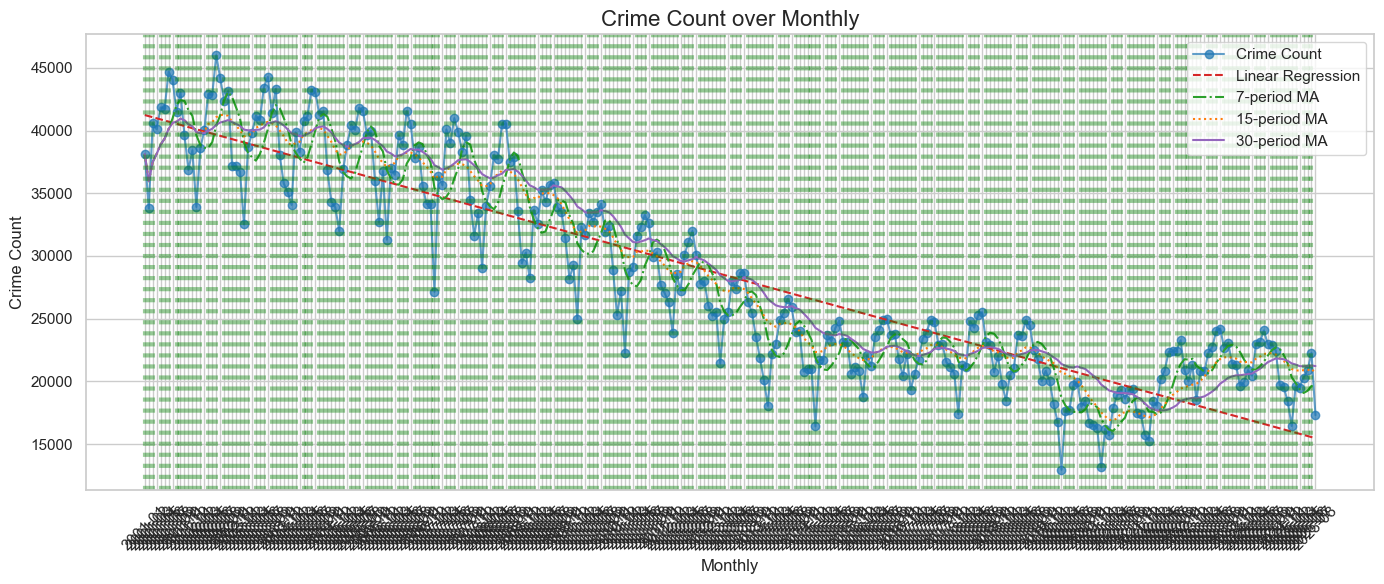

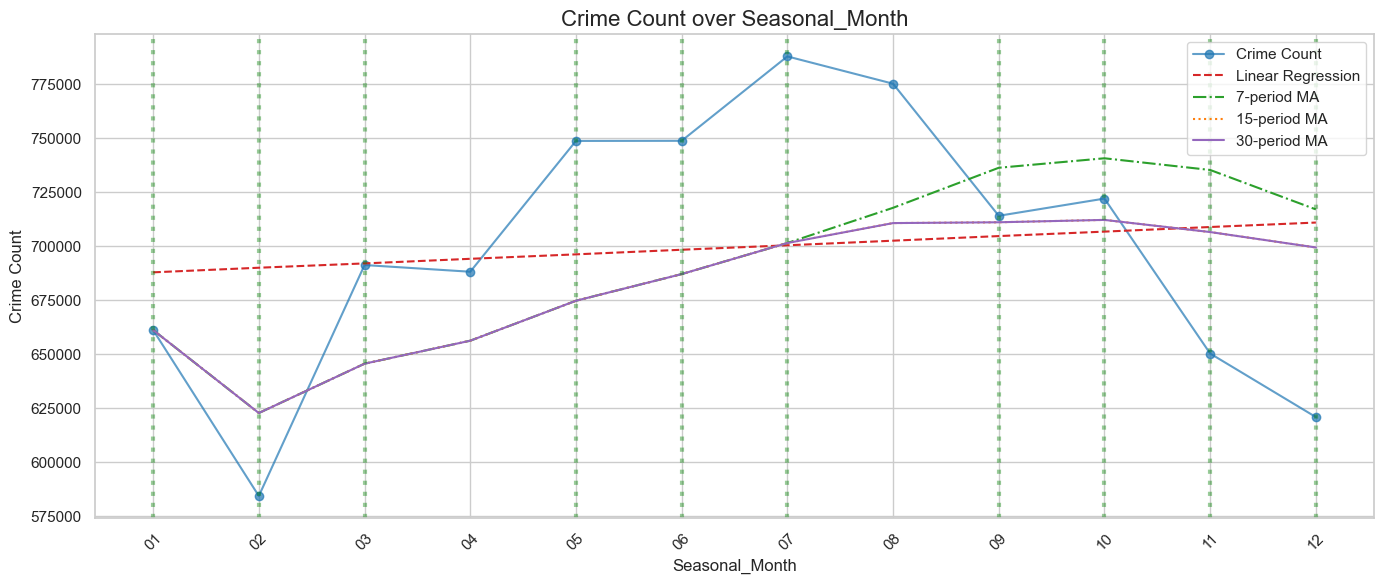

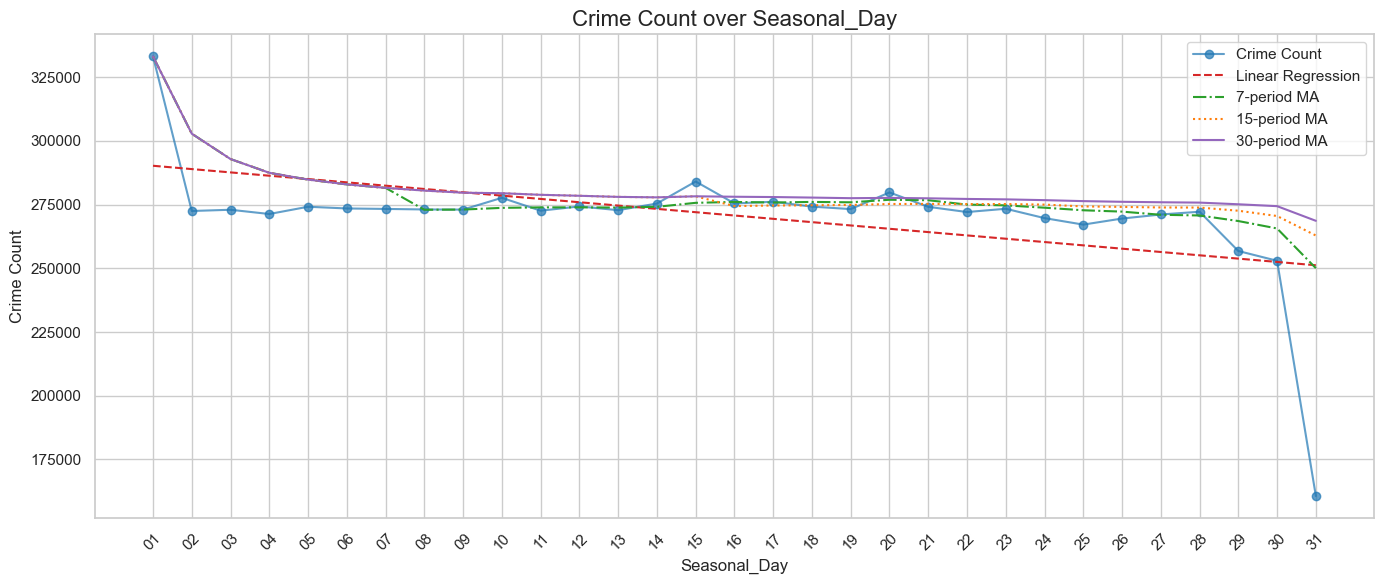

In [92]:
# plot_crime_count(crime_yearly, "Yearly")
plot_crime_count(crime_monthly, "Monthly")
plot_crime_count(crime_seasonal_month, "Seasonal_Month")
plot_crime_count(crime_seasonal_day, "Seasonal_Day")
# plot_crime_count(crime_daily, "Daily")
# plot_crime_count(crime_hourly, "Hourly") # takes a lot of time 

Finally store the output to S3 bucket

In [ ]:
# save_df_to_s3_parquet(crime_daily, "XYZ", "output/crime_daily.parquet")
# save_df_to_s3_parquet(crime_hourly, "XYZ", "output/crime_hourly.parquet") # we wont use this
# save_df_to_s3_parquet(crime_monthly, "XYZ", "output/crime_monthly.parquet")
# save_df_to_s3_parquet(crime_yearly, "XYZ", "output/crime_yearly.parquet")
# save_df_to_s3_parquet(crime_seasonal_day, "XYZ", "output/crime_seasonal_day.parquet")
# save_df_to_s3_parquet(crime_seasonal_month, "XYZ", "output/crime_seasonal_month.parquet")